In [163]:
import os 

import numpy as np
import pandas as pd
import scipy 

import progressbar

import re
import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

% matplotlib inline


In [21]:
data = pd.read_csv('../data/All_data.csv', encoding='latin1')
data.columns.values

array(['Unnamed: 0', u'rowHash', u'Id', u'Title', u'Description',
       u'LikeCount', u'DislikeCount', u'ViewCount', u'FavoriteCount',
       u'CommentCount', u'PublishedAt', u'Channel Id', u'Channel Title',
       u'Lang', u'publishedAt', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'nextHash', u'PrevCommentCount',
       u'PrevDislikeCount', u'PrevLikeCount', u'PrevPublishedAt',
       u'PrevViewCount', u'PrevTitle', u'PublishedYear', u'ChannelAge'], dtype=object)

In [3]:
data.shape

(92458, 27)

In [4]:
df = data.copy()

In [5]:
def tokenize(s):
    regex_backslash = re.compile(r'\\n|\\')
    s = (regex_backslash.sub(" ", s))
    tokenizer = RegexpTokenizer(r'[\w\']+|![^\w\s]+')
    return tokenizer.tokenize(s)
    
def num_tokens_in_str(s):
    s = tokenize(s)
    return len(s)

def top_k_percentile_views_mask(df, k):
    top_k_percent = df['ViewCount'].nlargest(int(df.shape[0] * (k / 100.))).iloc[-1]
    return df['ViewCount'] > top_k_percent

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def GetTopKImportantWords(df, k, showprogress=False):
    allWords = df[['Title', 'Description']].apply(lambda x: x[0] + x[1], axis=1)

    tf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize)
    tf.fit(allWords)

    tfidf_title = tf.transform(df['Title'])
    tfidf_desc = tf.transform(df['Description'])
    top_list = []


    for tfidf in [tfidf_title, tfidf_desc]:
        dense = tfidf.todense()

        if showprogress:
            bar = progressbar.ProgressBar(max_value=len(dense))

        top_words = []
        feature_names = tf.get_feature_names()
        for i, sample in enumerate(dense):
            sample = np.array(sample.tolist()[0])
            scores = sample[sample > 0]
            words = pd.Series(feature_names)[sample > 0]
            scores = pd.Series(scores, words).sort_values(ascending=False)
            top_words.append(pd.Series(scores.index[0:k]))
            
            if showprogress:
                bar.update(i)
        top_list.append(pd.concat(top_words, axis=1).T)

    for i in range(k):
        df['Title-TopWords-{0}'.format(i + 1)] = top_list[0][i]
    for i in range(k):
        df['Description-TopWords-{0}'.format(i + 1)] = top_list[1][i]
    return df

In [7]:
# Trying to find some relationship between what's present in the titles.
def find_number_of_condition(s, condition):
    s = tokenize(s)
    num_detected_condition = 0 
    for token in s:
        if condition(token):
            num_detected_condition += 1
    return num_detected_condition

def num_words_all_caps(s):
    return find_number_of_condition(s, lambda x: x.isupper())

def num_how(s):
    return find_number_of_condition(s, lambda x: x.lower() == 'how')

def num_absolutes(s):
    absolute_words = ['best', 'most', 'never', 'top', 'guarantees', 'guaranteed', 'extreme']
    return find_number_of_condition(s, lambda x: x.lower() in absolute_words)

def num_exclamation(s):
    return s.count('!')

def num_me(s):
    # e.g. any time they say me or i
    me_words = ['i', 'me', 'my', 'mine', 'myself']
    return find_number_of_condition(s, lambda x: x.lower() in me_words)

def num_you(s):
    you_words = ['you', 'your', 'yours', 'yourself']
    return find_number_of_condition(s, lambda x: x.lower() in you_words)

condition_map = {
    'caps': num_words_all_caps,
    'how': num_how,
    'absolutes': num_absolutes, 
    'exclamations': num_exclamation,
    'me': num_me,
    'you': num_you,
}

In [8]:
df_t = df.copy()

new_columns = []
for key in condition_map.keys():
    column_name = 'num-{0}'.format(key)
    df_t[column_name] = df['Title'].astype(str).apply(condition_map[key])
    new_columns.append(column_name)
df_t = df_t[new_columns]
df_t['ViewCount'] = df['ViewCount']
df_t['Title'] = df['Title']

df_t['TotalUses'] = df_t['Title'].apply(lambda x: 0)
for new_column in new_columns:
    df_t['TotalUses'] += df_t[new_column]

df_t.head()

,num-me,num-caps,num-how,num-you,num-exclamations,num-absolutes,ViewCount,Title,TotalUses
0,0,0,0,0,0,0,18,Depeche Mode It's No Good,0
1,0,0,0,0,0,1,3911,the best of Jay cutler Dorian Yates,1
2,0,4,0,0,0,0,3853,Iron Man Andy photos NO PAIN NO GAIN,4
3,0,0,0,0,0,0,56,Mooring Anchor Carry 120kg at Papar Strongestm...,0
4,0,0,0,0,0,0,74,Tire Flip 450kg at Papar Strongestman 2016,0


In [10]:
k = 15
top_k_mask = top_k_percentile_views_mask(df, k)

for new_column in new_columns:
    top_k_used = (df_t[top_k_mask][new_column] > 0).sum() / (float(df_t[top_k_mask].shape[0]))
    total_used = (df_t[new_column] > 0).sum() / float(df_t.shape[0])
    print ("In top {0} percentile, {1}% used {2}".format(k, top_k_used, new_column))
    print ("In total, {0}% used a {1}".format(total_used, new_column))

In top 15 percentile, 0.0260152284264% used num-me
In total, 0.027384235048% used a num-me
In top 15 percentile, 0.368654822335% used num-caps
In total, 0.352857278692% used a num-caps
In top 15 percentile, 0.0583756345178% used num-how
In total, 0.0354663877532% used a num-how
In top 15 percentile, 0.0361675126904% used num-you
In total, 0.0285252448417% used a num-you
In top 15 percentile, 0.0951776649746% used num-exclamations
In total, 0.0665589046306% used a num-exclamations
In top 15 percentile, 0.0469543147208% used num-absolutes
In total, 0.0249120471617% used a num-absolutes


In [46]:
df_t[top_k_mask]['TotalUses'].describe()

count    1050.00000
mean        1.20000
std         1.96247
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max        14.00000
Name: TotalUses, dtype: float64

In [47]:
(df_t[top_k_mask]['TotalUses'] > 0).sum()

500

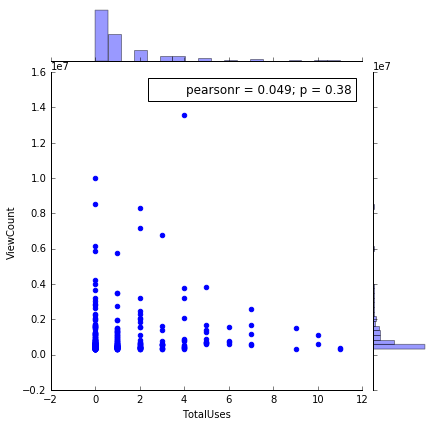

In [31]:
sns.jointplot(df_t[top_k_mask]['TotalUses'], df_t[top_k_mask]['ViewCount'])

In [13]:
def top_k_percentile_views_mask(df, k):
    top_k_percent = df['ViewCount'].nlargest(int(df.shape[0] * (k / 100.))).iloc[-1]
    return df['ViewCount'] > top_k_percent
def bottom_k_percentile_views_mask(df, k):
    bottom_k_percent = df['ViewCount'].nsmallest(int(df.shape[0] * (k / 100.))).iloc[-1]
    return df['ViewCount'] < bottom_k_percent

In [14]:
df_t = df[top_k_percentile_views_mask(df, 10)]
df_b = df[bottom_k_percentile_views_mask(df, 10)]

In [15]:
df_t = GetTopKImportantWords(df_t, 3, showprogress=True)

 99% (9233 of 9244) |#################### | Elapsed Time: 0:01:06 ETA:  0:00:00C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
df_b = GetTopKImportantWords(df_b, 3, showprogress=True)

 99% (9160 of 9168) |#################### | Elapsed Time: 0:00:43 ETA:  0:00:00C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [130]:
def getWordCountMap(df):
    wordCountMap = {}
    for i, row in df.iterrows():
        columns = ['Title', 'PrevTitle']
        for col in columns:
            tokens = tokenize(row[col].lower())
            for word in tokens:
                if word not in wordCountMap:
                    wordCountMap[word] = 1
                else:
                    wordCountMap[word] += 1
    return wordCountMap

In [131]:
def getNGramMap(df, n):
    nGramMap = {}
    for i, row in df.iterrows():
        columns = ['Title', 'PrevTitle']
        for col in columns:
            tokens = tokenize(row[col].lower())
            ngrams = nltk.ngrams(tokens, n)
            for ngram in ngrams:
                linked = ''
                for gram in ngram:
                    linked += gram + ' '
                if linked not in nGramMap:
                    nGramMap[linked] = 1
                else:
                    nGramMap[linked] += 1
    return nGramMap

In [132]:
wcm = getWordCountMap(df)

In [133]:
sorted_wcm = sorted(wcm.iteritems(), key=lambda (k,v):(v,k), reverse=True)

In [134]:
sorted_wcm

[(u'the', 30151),
 (u'to', 20400),
 (u'and', 18151),
 (u'workout', 15685),
 (u'with', 13090),
 (u'of', 12747),
 (u'for', 12715),
 (u'a', 11741),
 (u'in', 10047),
 (u'training', 9926),
 (u'how', 9377),
 (u'2', 8438),
 (u'at', 8185),
 (u'1', 7308),
 (u'fitness', 7296),
 (u'day', 7185),
 (u'3', 6463),
 (u'on', 6289),
 (u'your', 5419),
 (u'body', 5338),
 (u'part', 4910),
 (u'gym', 4849),
 (u'back', 4727),
 (u'bodybuilding', 4628),
 (u'5', 4518),
 (u'up', 4360),
 (u'my', 4310),
 (u'you', 4305),
 (u'muscle', 4209),
 (u'by', 3912),
 (u'4', 3833),
 (u'2017', 3823),
 (u'press', 3743),
 (u'week', 3492),
 (u'i', 3315),
 (u'new', 3297),
 (u'from', 3229),
 (u'bench', 3188),
 (u'review', 3130),
 (u'exercise', 3122),
 (u'is', 3106),
 (u'squat', 3099),
 (u'video', 3097),
 (u'out', 2979),
 (u'10', 2936),
 (u'chest', 2925),
 (u'2013', 2915),
 (u'motivation', 2902),
 (u'exercises', 2890),
 (u'challenge', 2880),
 (u'vs', 2857),
 (u'weight', 2847),
 (u'best', 2812),
 (u'get', 2777),
 (u'strength', 2759),
 

In [164]:
nGramMap = getNGramMap(df, 3)

In [165]:
sorted_nGramMap = sorted(nGramMap.iteritems(), key=lambda(k,v):(v,k), reverse=True)

In [166]:
sorted_nGramMap

[(u'how to get ', 803),
 (u'how to do ', 713),
 (u'how to make ', 556),
 (u'of the week ', 414),
 (u'day of eating ', 410),
 (u'full day of ', 390),
 (u'pipe band championships ', 341),
 (u'six pack abs ', 323),
 (u'to do a ', 314),
 (u'behind the scenes ', 312),
 (u'how to build ', 294),
 (u'in the gym ', 284),
 (u'day in the ', 283),
 (u'to lose weight ', 274),
 (u'road to the ', 256),
 (u'in the life ', 243),
 (u'full body workout ', 239),
 (u'weeks out from ', 232),
 (u'how to lose ', 221),
 (u'clean and jerk ', 211),
 (u'district pipe band ', 208),
 (u'to build muscle ', 204),
 (u'for fat loss ', 180),
 (u'black and white ', 172),
 (u'to get a ', 168),
 (u'upper body workout ', 165),
 (u'female fitness motivation ', 165),
 (u'the truth about ', 164),
 (u'pipe band at ', 164),
 (u'how to use ', 163),
 (u'get rid of ', 163),
 (u'for weight loss ', 160),
 (u'pokemon black and ', 154),
 (u'5 weeks out ', 154),
 (u'you need to ', 148),
 (u'part 2 of ', 148),
 (u'vale of atholl ', 144),

In [138]:
nGramMap = getNGramMap(df, 2)

In [139]:
sorted_nGramMap = sorted(nGramMap.iteritems(), key=lambda(k,v):(v,k), reverse=True)

In [140]:
sorted_nGramMap

[(u'how to ', 7656),
 (u'of the ', 2106),
 (u'pipe band ', 2071),
 (u'in the ', 2023),
 (u'at the ', 1933),
 (u'bench press ', 1564),
 (u'part 2 ', 1488),
 (u'part 1 ', 1366),
 (u'on the ', 1363),
 (u'to get ', 1244),
 (u'bodybuilding motivation ', 1219),
 (u'to the ', 1198),
 (u'to do ', 1005),
 (u'weight loss ', 989),
 (u'for the ', 969),
 (u'weeks out ', 890),
 (u'road to ', 889),
 (u'ifbb pro ', 806),
 (u'q a ', 758),
 (u'the best ', 755),
 (u'workout with ', 723),
 (u'workout for ', 718),
 (u'at home ', 707),
 (u'to make ', 700),
 (u'upper body ', 699),
 (u'fat loss ', 694),
 (u'the gym ', 679),
 (u'muay thai ', 662),
 (u'with the ', 642),
 (u'body workout ', 636),
 (u'full body ', 628),
 (u'exercises for ', 614),
 (u'for a ', 613),
 (u'chest workout ', 605),
 (u'arnold classic ', 593),
 (u'day of ', 583),
 (u'push up ', 576),
 (u'warm up ', 566),
 (u'from the ', 564),
 (u'part 3 ', 563),
 (u'personal trainer ', 552),
 (u'six pack ', 533),
 (u'back workout ', 513),
 (u'push ups ',

In [156]:
del wcm['for']

In [147]:
sorted_wcm

[(u'the', 30151),
 (u'to', 20400),
 (u'and', 18151),
 (u'workout', 15685),
 (u'with', 13090),
 (u'of', 12747),
 (u'for', 12715),
 (u'a', 11741),
 (u'in', 10047),
 (u'training', 9926),
 (u'how', 9377),
 (u'2', 8438),
 (u'at', 8185),
 (u'1', 7308),
 (u'fitness', 7296),
 (u'day', 7185),
 (u'3', 6463),
 (u'on', 6289),
 (u'your', 5419),
 (u'body', 5338),
 (u'part', 4910),
 (u'gym', 4849),
 (u'back', 4727),
 (u'bodybuilding', 4628),
 (u'5', 4518),
 (u'up', 4360),
 (u'my', 4310),
 (u'you', 4305),
 (u'muscle', 4209),
 (u'by', 3912),
 (u'4', 3833),
 (u'2017', 3823),
 (u'press', 3743),
 (u'week', 3492),
 (u'i', 3315),
 (u'new', 3297),
 (u'from', 3229),
 (u'bench', 3188),
 (u'review', 3130),
 (u'exercise', 3122),
 (u'is', 3106),
 (u'squat', 3099),
 (u'video', 3097),
 (u'out', 2979),
 (u'10', 2936),
 (u'chest', 2925),
 (u'2013', 2915),
 (u'motivation', 2902),
 (u'exercises', 2890),
 (u'challenge', 2880),
 (u'vs', 2857),
 (u'weight', 2847),
 (u'best', 2812),
 (u'get', 2777),
 (u'strength', 2759),
 

In [157]:
wc = WordCloud().generate_from_frequencies(wcm)

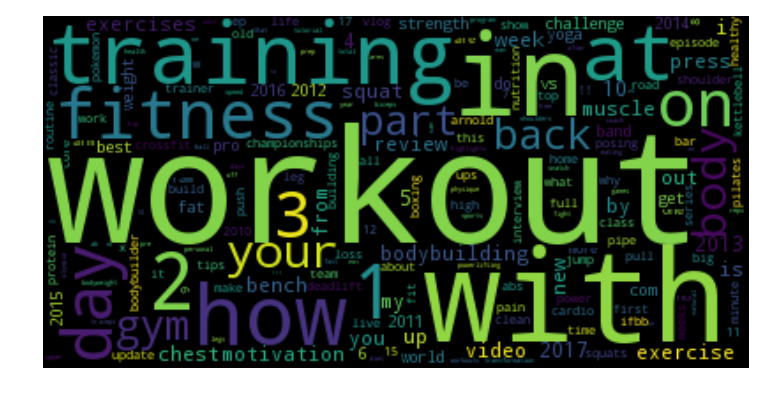

In [162]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wc)
plt.axis('off')
plt.show()

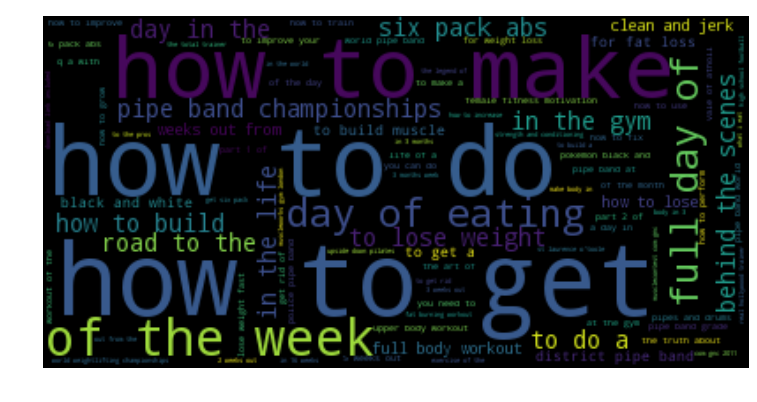

In [167]:
wc = WordCloud().generate_from_frequencies(nGramMap)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(wc)
plt.axis('off')
plt.show()